# Titanic Survival Prediction

Notebook này hướng dẫn bạn tham gia cuộc thi Titanic trên Kaggle. Mục tiêu: Dự đoán hành khách nào sống sót sau vụ đắm tàu.

Dữ liệu:
- train.csv: Dữ liệu huấn luyện với nhãn 'Survived'.
- test.csv: Dữ liệu kiểm tra, cần dự đoán.

Điểm số đánh giá: Accuracy trên Kaggle leaderboard.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho plot
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Tải Dữ Liệu

In [4]:
# Tải dữ liệu
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Hiển thị thông tin cơ bản
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain info:")
print(train_df.info())
print("\nFirst 5 rows of train:")
print(train_df.head())

Train shape: (891, 12)
Test shape: (418, 11)

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

First 5 rows of train:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            

## 2. Exploratory Data Analysis (EDA)
Phân tích phân bố dữ liệu, missing values, và mối quan hệ với 'Survived'.

Missing values in train:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Descriptive statistics:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381

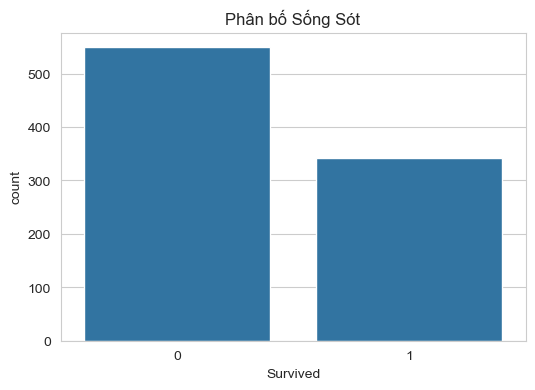

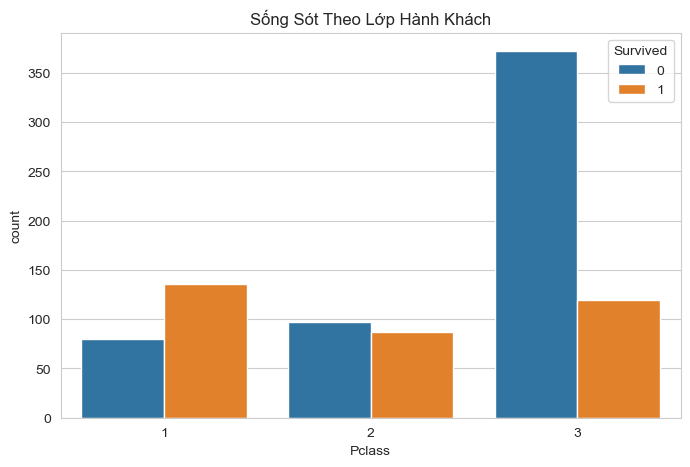

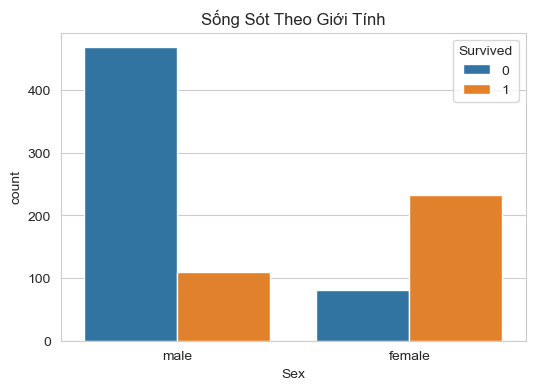

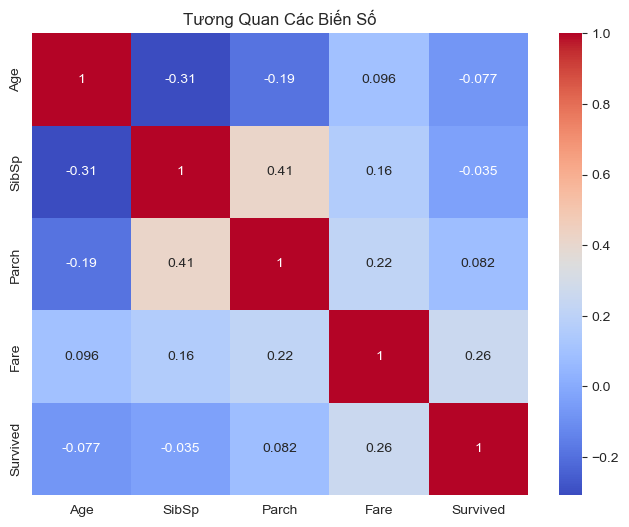

In [5]:
# Missing values
print("Missing values in train:")
print(train_df.isnull().sum())

# Thống kê mô tả
print("\nDescriptive statistics:")
print(train_df.describe())

# Phân bố Survived
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=train_df)
plt.title('Phân bố Sống Sót')
plt.show()

# Phân bố theo Pclass
plt.figure(figsize=(8,5))
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Sống Sót Theo Lớp Hành Khách')
plt.show()

# Phân bố theo Sex
plt.figure(figsize=(6,4))
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Sống Sót Theo Giới Tính')
plt.show()

# Heatmap tương quan (chỉ số num)
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
corr = train_df[num_cols + ['Survived']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Tương Quan Các Biến Số')
plt.show()

## 3. Feature Engineering và Xử Lý Missing Values
- Điền Age bằng median theo Pclass.
- Điền Embarked bằng mode.
- Tạo feature FamilySize = SibSp + Parch + 1.
- Encode categorical: Sex (male=0, female=1), Embarked (one-hot).
- Bỏ Cabin (quá nhiều missing).

In [6]:
# Kết hợp train và test để xử lý chung
combined = pd.concat([train_df, test_df], sort=False, ignore_index=True)

# Xử lý Age: Điền median theo Pclass
combined['Age'] = combined.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

# Xử lý Embarked: Điền mode
combined['Embarked'] = combined['Embarked'].fillna(combined['Embarked'].mode()[0])

# Tạo FamilySize
combined['FamilySize'] = combined['SibSp'] + combined['Parch'] + 1

# Tạo IsAlone
combined['IsAlone'] = (combined['FamilySize'] == 1).astype(int)

# Encode Sex
combined['Sex'] = combined['Sex'].map({'male': 0, 'female': 1})

# One-hot encode Embarked
combined = pd.get_dummies(combined, columns=['Embarked'], prefix='Emb')

# Bỏ các cột không cần: Name, Ticket, Cabin, PassengerId (giữ cho test)
drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
combined = combined.drop(drop_cols, axis=1)

# Tách lại train và test
train = combined[:len(train_df)]
test = combined[len(train_df):]

# Tách X, y
X = train.drop('Survived', axis=1)
y = train['Survived']

print("Processed train shape:", X.shape)
print("Processed test shape:", test.shape)
print("\nFirst 5 rows of processed X:")
print(X.head())

Processed train shape: (891, 11)
Processed test shape: (418, 12)

First 5 rows of processed X:
   Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  IsAlone  Emb_C  \
0       3    0  22.0      1      0   7.2500           2        0  False   
1       1    1  38.0      1      0  71.2833           2        0   True   
2       3    1  26.0      0      0   7.9250           1        1  False   
3       1    1  35.0      1      0  53.1000           2        0  False   
4       3    0  35.0      0      0   8.0500           1        1  False   

   Emb_Q  Emb_S  
0  False   True  
1  False  False  
2  False   True  
3  False   True  
4  False   True  


## 4. Model Building và Training
Sử dụng Random Forest Classifier (dễ dùng và hiệu quả cho dataset nhỏ).

Validation Accuracy: 0.8156

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       110
         1.0       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



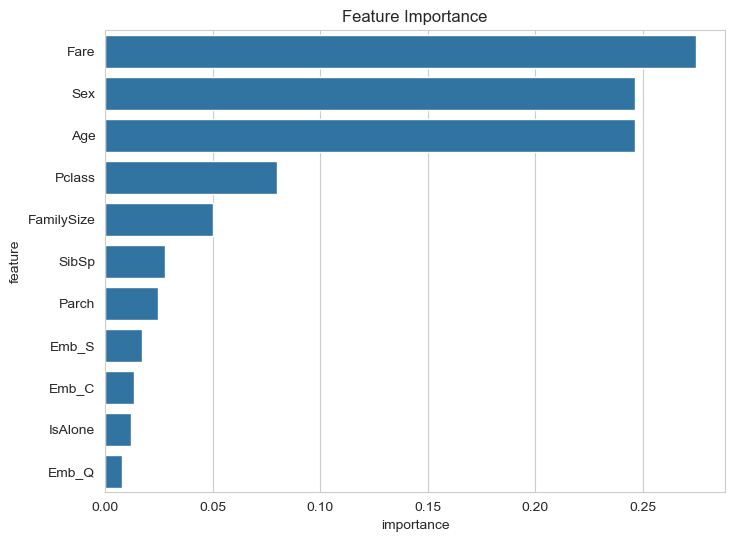

In [7]:
# Chia dữ liệu train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Khởi tạo mô hình
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Huấn luyện
model.fit(X_train, y_train)

# Dự đoán trên val
y_pred = model.predict(X_val)

# Đánh giá
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Feature importance
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feat_imp = feat_imp.sort_values('importance', ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('Feature Importance')
plt.show()

## 5. Prediction trên Test Set và Tạo File Submit
Tạo file CSV để upload lên Kaggle.

In [9]:
# Dự đoán trên test
test_ids = test_df['PassengerId']  # Lấy PassengerId từ test gốc
test_features = test.drop('Survived', axis=1, errors='ignore')  # Đảm bảo không có Survived
y_test_pred = model.predict(test_features)

# Ép kiểu về integer để tránh 0.0/1.0
y_test_pred = y_test_pred.astype(int)

# Tạo submission
submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': y_test_pred})
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")
print(submission.head())
print(f"Shape: {submission.shape}")

Submission file created: submission.csv
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         1
4          896         0
Shape: (418, 2)


## 6. Kết Luận
- Accuracy validation khoảng 0.80-0.82 (tùy run).
- Để cải thiện: Thử GridSearchCV, thêm feature (như Title từ Name), ensemble models (XGBoost, Logistic).

Upload `submission.csv` lên Kaggle để xem leaderboard score!

Nếu cần chỉnh sửa hoặc thêm phần, hãy cho tôi biết.